In this notebook, we investigate the ability of properly weighted stefcal to suppress fine frequency structure in the calibration solution.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from stefcal_uvdata import StefcalUVData
from data import DATA_PATH
import matplotlib.pyplot as plt
import delayGridding as dg
import stefcal_utils as suv
import copy

In [2]:
#initialize stefcal object 
complete_vis_path=os.path.join(DATA_PATH,
                               'mwa_complete/mwa_complete/'
                               '2017-05-31-20-47-15/simdata/simvis-noiseless.uvfits')
complete_vis_noisy_path=os.path.join(DATA_PATH,
                                      'mwa_complete/mwa_complete/'
                                      '2017-05-31-20-47-15/simdata/simvis-noisy.uvfits')
incomplete_vis_path=os.path.join(DATA_PATH,
                                 'mwa_incomplete/mwa_incomplete/'
                                 '2017-05-31-20-44-17/simdata/simvis-noiseless.uvfits')
incomplete_vis_noisy_path=os.path.join(DATA_PATH,
                                       'mwa_incomplete/mwa_incomplete/'
                                       '2017-05-31-20-44-17/simdata/simvis-noisy.uvfits')

Initialize a uvdata set with the model equal to the data to derive perfect calibration solutions from.

In [3]:
stefcal_perfect=StefcalUVData()
stefcal_perfect.from_uvfits(complete_vis_path,complete_vis_path,
                           flag_weights_fromdata=True)    

stefcal_perfect.measured_vis.data_array=stefcal_perfect.measured_vis.data_array.astype('complex128')
stefcal_perfect.model_vis.data_array=stefcal_perfect.model_vis.data_array.astype('complex128')

freqs=stefcal_perfect.measured_vis.freq_array
npol=stefcal_perfect.measured_vis.Npols
nant=stefcal_perfect.measured_vis.Nants_data

Simulate some gains with reflections.

In [4]:
gains=np.ones_like(stefcal_perfect.uvcal.gain_array)
mean_amp=1e-1
std_amp=5e-2
amps=np.abs(np.random.randn(nant,npol)*std_amp+mean_amp)
mean_delay=200e-9
std_delay=30e-9
delays=np.abs(np.random.randn(nant,npol)*std_delay+mean_delay)
phases=np.random.rand(nant,npol)
for pol in range(npol):
    for ant in range(nant):
        d=delays[ant,pol].squeeze()
        a=amps[ant,pol].squeeze()
        p=phases[ant,pol].squeeze()
        gains[ant,0,:,0,pol]=1./(1.+a*np.exp(2j*np.pi*(freqs*d+p)))
#set the reference antenna phases to zero!
gains[0,0,:,0,:]=np.abs(gains[0,0,:,0,:])
test_gains=stefcal_perfect.uvcal_from_data()
test_gains.gain_array=gains


Set parameters in perfect calibration and run.

In [5]:
#read in uvfits data and model files
#set calibration parameters
stefcal_perfect.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':1,
                           'n_phase_iter':5,
                           'refant':0,
                           't_avg':1})      

stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains,applyGains=True)
stefcal_perfect.stefcalibrate()
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains)
gains_estimated=stefcal_perfect.uvcal.gain_array

Now run calibration for an incomplete model with no attemp to weight the visibilities. 

In [6]:
#read in uvfits data and model files
stefcal_errors=StefcalUVData()
stefcal_errors.from_uvfits(complete_vis_path,incomplete_vis_path,
                           flag_weights_fromdata=True)    


stefcal_errors.measured_vis.data_array=stefcal_errors.measured_vis.data_array.astype('complex128')
stefcal_errors.model_vis.data_array=stefcal_errors.model_vis.data_array.astype('complex128')

#set calibration parameters
stefcal_errors.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':3,
                           'n_phase_iter':5,
                           'refant':0,
                           't_avg':1})      
freqs=stefcal_errors.measured_vis.freq_array
npol=stefcal_errors.measured_vis.Npols
nant=stefcal_errors.measured_vis.Nants_data


In [7]:
stefcal_errors.measured_vis=suv.correct_vis(stefcal_errors.measured_vis,test_gains,applyGains=True)
stefcal_errors.stefcalibrate()
stefcal_errors.measured_vis=suv.correct_vis(stefcal_errors.measured_vis,test_gains)
gains_estimated_errors=stefcal_errors.uvcal.gain_array

Generate weights and flags for weighted calibration. 

In [8]:
#read in uvfits data and model files
stefcal_weighted=StefcalUVData()
stefcal_weighted.from_uvfits(complete_vis_path,incomplete_vis_path,
                             flag_weights_fromdata=True)    

#set_model_data(stefcal_weighted.model_vis,array_model)
#set_model_data(stefcal_weighted.measured_vis,array_data)

stefcal_weighted.measured_vis.data_array=stefcal_weighted.measured_vis.data_array.astype('complex128')
stefcal_weighted.model_vis.data_array=stefcal_weighted.model_vis.data_array.astype('complex128')


SIGMA_W=25.
nflag,antflags,trimflags,weights=suv.generate_gaussian_weights(SIGMA_W,
                                                               stefcal_weighted.model_vis,
                                                               modelweights=True,
                                                               trim_neff=True)

neff.min=2.00061893463
nflag=53


set weighted calibration parameters.

In [9]:
#set calibration parameters
stefcal_weighted.set_params({'trim_neff':True,
                             'min_ant_times':1,
                             'eps':1e-10,
                             'min_bl_per_ant':2,
                             'n_cycles':10,
                             'n_phase_iter':5,
                             'refant':0,
                             't_avg':1,
                             'weights':weights,
                             'flags':trimflags})     
freqs=stefcal_weighted.measured_vis.freq_array
npol=stefcal_weighted.measured_vis.Npols
nant=stefcal_weighted.measured_vis.Nants_data


run calibration. 

In [10]:

stefcal_weighted.measured_vis=suv.correct_vis(stefcal_weighted.measured_vis,test_gains,applyGains=True)
stefcal_weighted.stefcalibrate()
stefcal_weighted.measured_vis=suv.correct_vis(stefcal_weighted.measured_vis,test_gains)
gains_estimated_weighted=stefcal_weighted.uvcal.gain_array

copy all three calibration solutions.

In [14]:
imperfect_gains=copy.deepcopy(test_gains)
imperfect_gains.gain_array=gains_estimated_errors

In [15]:
perfect_gains=copy.deepcopy(test_gains)
perfect_gains.gain_array=gains_estimated

In [16]:
weighted_gains=copy.deepcopy(test_gains)
weighted_gains.gain_array=gains_estimated_weighted

Generate delay power-spectra of model-subtracted visibilities with the three different calibration solutions.

In [17]:
bl_flags=np.empty(8182,dtype=bool);bl_flags[:]=False
weighted_vis_flags=trimflags[:,0,0,0].squeeze()

stefcal_errors.measured_vis=suv.correct_vis(stefcal_errors.measured_vis,
                                            test_gains,applyGains=True)
stefcal_errors.measured_vis=suv.correct_vis(stefcal_errors.measured_vis,
                                            imperfect_gains)

ps_kperp,ps_kpara,ps_imperfect=dg.delayTransformAndGrid((stefcal_errors.measured_vis.data_array.squeeze()-\
                                                        stefcal_errors.model_vis.data_array.squeeze()).T,
                                                        np.linalg.norm(stefcal_errors.measured_vis.uvw_array,axis=1),
                                                        stefcal_errors.measured_vis.freq_array[0][100],
                                                        1e5,
                                                        100,
                                                        200,
                                                        4.,
                                                        weighted_vis_flags)

stefcal_errors.measured_vis=suv.correct_vis(stefcal_errors.measured_vis,
                                            imperfect_gains,applyGains=True)
stefcal_errors.measured_vis=suv.correct_vis(stefcal_errors.measured_vis,
                                            test_gains)


stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,
                                             test_gains,applyGains=True)
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,
                                             perfect_gains)

ps_kperp,ps_kpara,ps_perfect=dg.delayTransformAndGrid((stefcal_perfect.measured_vis.data_array.squeeze()-\
                                                      stefcal_errors.model_vis.data_array.squeeze()).T,
                                                      np.linalg.norm(stefcal_perfect.measured_vis.uvw_array,axis=1),
                                                      stefcal_perfect.measured_vis.freq_array[0][100],
                                                      1e5,
                                                      100,
                                                      200,
                                                      4.,
                                                      weighted_vis_flags)

stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,
                                             perfect_gains,applyGains=True)
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,
                                             test_gains)



stefcal_weighted.measured_vis=suv.correct_vis(stefcal_weighted.measured_vis,
                                              test_gains,applyGains=True)
stefcal_weighted.measured_vis=suv.correct_vis(stefcal_weighted.measured_vis,
                                              weighted_gains)

ps_kperp,ps_kpara,ps_weighted=dg.delayTransformAndGrid((stefcal_weighted.measured_vis.data_array.squeeze()-\
                                                      stefcal_weighted.model_vis.data_array.squeeze()).T,
                                                      np.linalg.norm(stefcal_weighted.measured_vis.uvw_array,axis=1),
                                                      stefcal_weighted.measured_vis.freq_array[0][100],
                                                      1e5,
                                                      100,
                                                      200,
                                                      4.,
                                                      weighted_vis_flags)

stefcal_weighted.measured_vis=suv.correct_vis(stefcal_weighted.measured_vis,
                                              weighted_gains,applyGains=True)
stefcal_weighted.measured_vis=suv.correct_vis(stefcal_weighted.measured_vis,
                                              test_gains)


Make some psuedo-color plots. We see that the perfect foreground model contains errors within the wedge. The imperfect model leaks errors into the EoR window, and the weighted model preserves the EoR window on short baselines. 

divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10


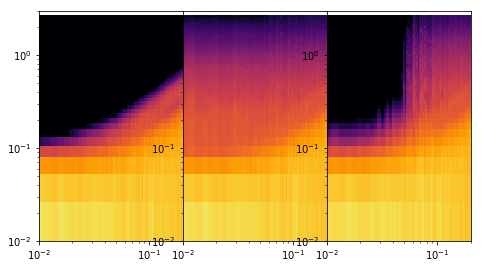

In [18]:
fig=plt.figure()
axarr=[fig.add_axes([.1+m/3.,.1,1./3,.8]) for m in range(3)]
ps_kperpg,ps_kparag=np.meshgrid(ps_kperp,ps_kpara)

psplot_perfect=np.log10(np.abs(ps_perfect*(86e-3/5.)**1.25))
psplot_perfect[np.isnan(psplot_perfect)]=0.
psplot_perfect[np.isinf(psplot_perfect)]=0.

psplot_errors=np.log10(np.abs(ps_imperfect*(86e-3/5.)**1.25))
psplot_errors[np.isnan(psplot_errors)]=0.
psplot_errors[np.isinf(psplot_errors)]=0.


psplot_weighted=np.log10(np.abs(ps_weighted*(86e-3/5.)**1.25))
psplot_weighted[np.isnan(psplot_weighted)]=0.
psplot_weighted[np.isinf(psplot_weighted)]=0.


axarr[0].pcolor(ps_kperpg,ps_kparag,psplot_perfect,vmin=3,vmax=13,cmap='inferno')
axarr[1].pcolor(ps_kperpg,ps_kparag,psplot_errors,vmin=3,vmax=13,cmap='inferno')
axarr[2].pcolor(ps_kperpg,ps_kparag,psplot_weighted,vmin=3,vmax=13,cmap='inferno')

for m in range(3):
    axarr[m].set_xscale('log')
    axarr[m].set_yscale('log')
    axarr[m].set_xlim(1e-2,2e-1)
    axarr[m].set_ylim(1e-2,3)

